#Import libraries

In [1]:
import os
import sys
from getpass import getpass
import git
import dropbox
import torch.optim as optim

#Configure environment

In [2]:
os.environ["ENVIRONMENT"] = "windows"
os.environ["REPO_DIR"] = git.Repo(search_parent_directories=True).git.rev_parse("--show-toplevel")
os.environ["ROOT_DIR"] = os.path.abspath(os.path.join(os.getenv("REPO_DIR"), os.pardir))
os.environ["MODEL_ID"] = "2y1a08e3"
os.environ["MODEL_DIR"] = f"{os.getenv('REPO_DIR')}/models/model_{os.getenv('MODEL_ID')}"

#Import repository resources

In [3]:
sys.path.append(f"{os.getenv('REPO_DIR')}/src")
from helpers import *

sys.path.append(f"{os.getenv('MODEL_DIR')}/src")
from methods import *
from architecture import *
from dataset import *

#Download datasets

In [4]:
dbx_access_token = "sl.BkVikVKQ33TQl4MjgHEgObfzyC6Y7ScPuCa-uDzpIccrnb5XCgeGHnKfvtT3TfG5C87hEZOMzG-HLXVl3hlb9sQV8yKLjXIDijJvUTfBrxwEuVCY15Z5Obq_1I2tXIa0f0zt6i72OS0e"#getpass("Enter your DropBox access token: ")

In [5]:
# download_datasets_from_dropbox(
#     dbx_access_token = dbx_access_token,
#     include_all_datasets = True,
#     use_thread = True
# )

#Code

In [6]:
num_epochs = 100
batch_size = 32
val_size = 50

In [7]:
device = set_device()
model = initialize_model(device=device, dbx_access_token=dbx_access_token, reset_weights=True)

train_dataset, val_dataset, benchmark_dataset = create_datasets(
    device = device,
    include_all_datasets = False,
    datasets = ["unity/flat_ground_13", "real_world/f22_parking_lot_3"]
)

train_dataloader, val_dataloader, benchmark_dataloader = create_dataloaders(
    train_dataset = train_dataset,
    val_dataset = val_dataset,
    benchmark_dataset = benchmark_dataset,
    batch_size = batch_size,
    val_size = val_size
)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
# criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 1.0], device=device))

Using GPU!


In [8]:
model, train_loss_hist, val_performance_hist, best_val_performance = training_loop(
    model = model,
    criterion = criterion,
    optimizer = optimizer,
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    dbx_access_token = dbx_access_token,
    num_epochs = num_epochs,
    critiqueing_metric = "Mean Pixel Accuracy",
    auto_stop = True
)

Training:   0%|          | 0/100 [00:00<?, ?epoch/s]

Epoch: 1/100  <>  Train Loss: 0.6995  <>  Val MPA: 25.12%  <>  Val Precision: 0.47%
Epoch: 5/100  <>  Train Loss: 0.6968  <>  Val MPA: 25.77%  <>  Val Precision: 0.52%
Epoch: 10/100  <>  Train Loss: 0.6950  <>  Val MPA: 26.26%  <>  Val Precision: 0.53%
Epoch: 15/100  <>  Train Loss: 0.6942  <>  Val MPA: 26.29%  <>  Val Precision: 0.58%
Epoch: 20/100  <>  Train Loss: 0.6938  <>  Val MPA: 26.28%  <>  Val Precision: 0.60%
Epoch: 25/100  <>  Train Loss: 0.6935  <>  Val MPA: 26.52%  <>  Val Precision: 0.69%
Epoch: 30/100  <>  Train Loss: 0.6934  <>  Val MPA: 26.41%  <>  Val Precision: 0.67%
Epoch: 35/100  <>  Train Loss: 0.6934  <>  Val MPA: 26.49%  <>  Val Precision: 0.62%
Epoch: 38/100  <>  Train Loss: 0.6934  <>  Val MPA: 26.45%  <>  Val Precision: 0.62%
Training auto stopped. No improvement in validation accuracy for 15 epochs.
Uploaded model weights to Dropbox.


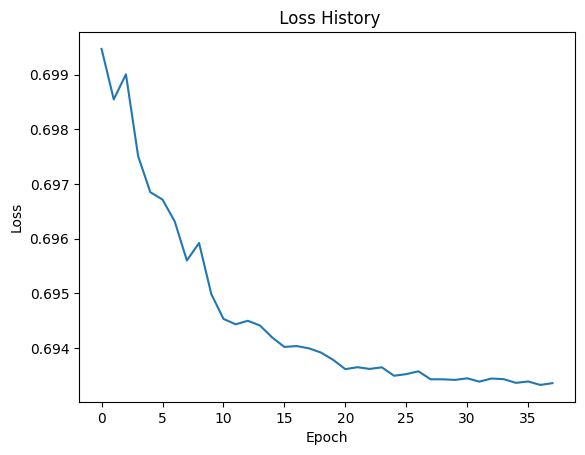

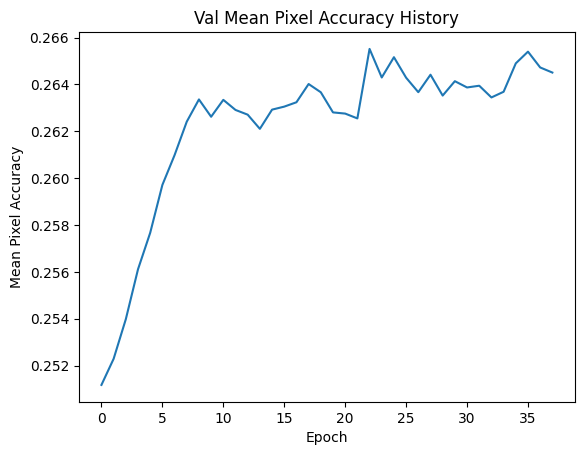

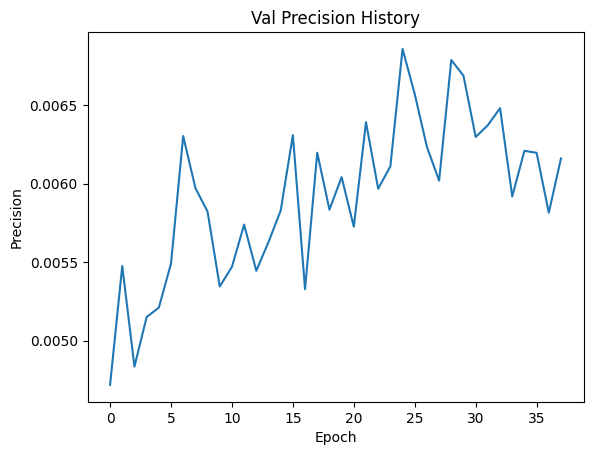

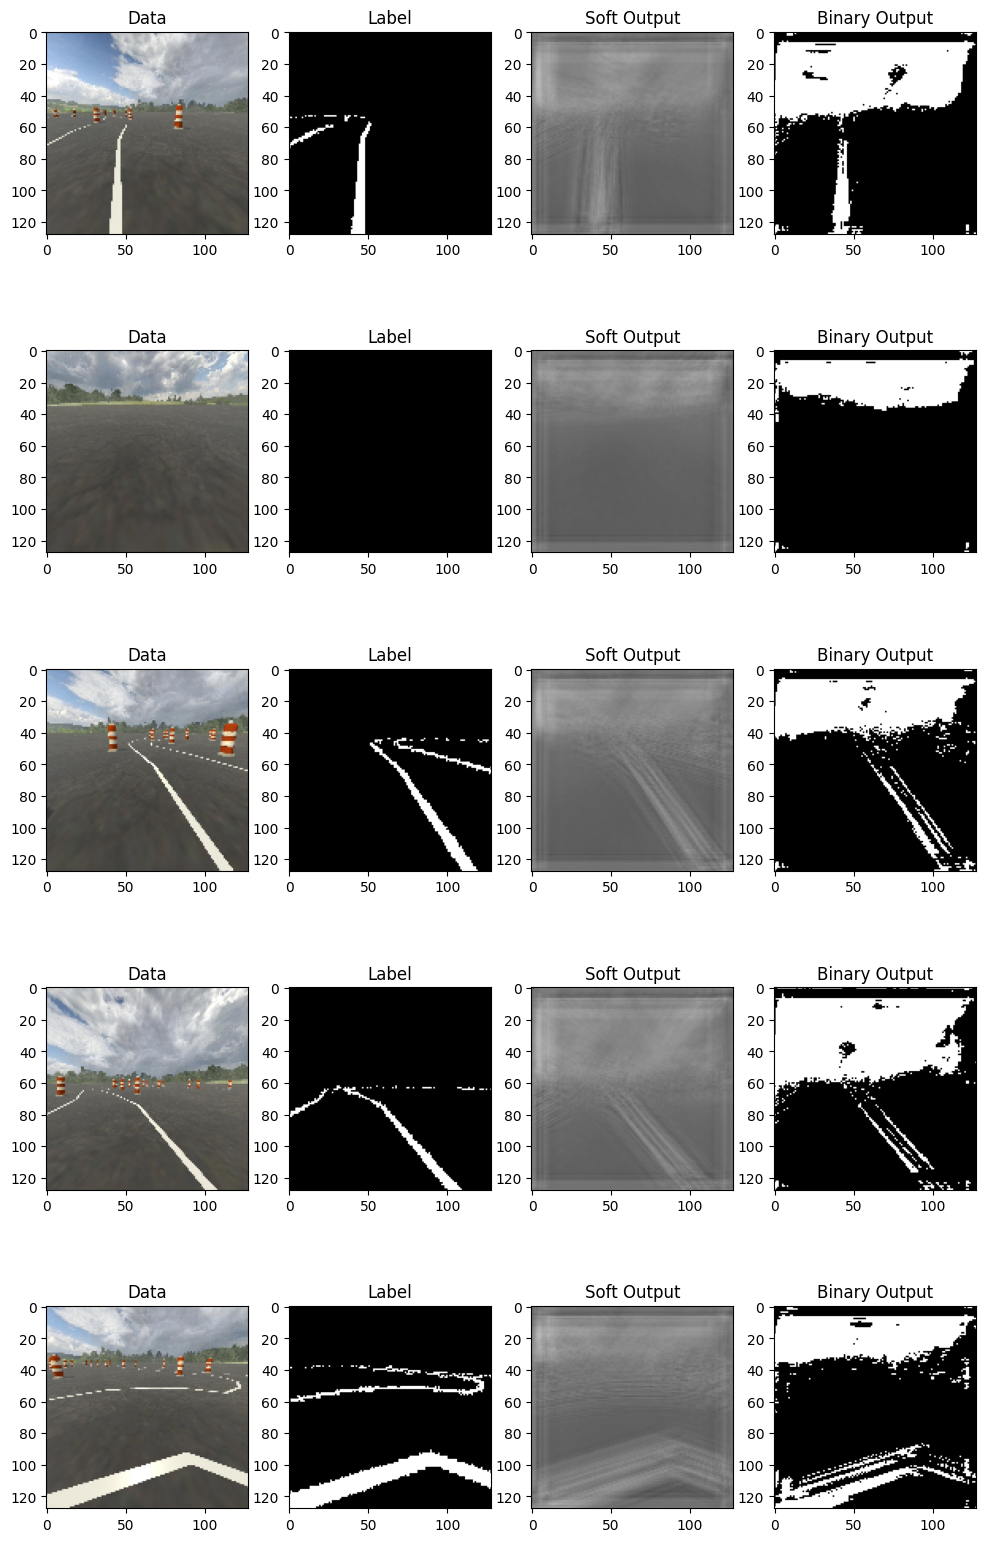

In [9]:
graph_loss_history(train_loss_hist)

graph_performance_history(
    performance_hist = val_performance_hist,
    split = 'Val',
    metrics = ["Mean Pixel Accuracy", "Precision"]
)

show_sample_results(
    model = model,
    dataset = train_dataset,
    device = device,
)

Testing on benchmark_1:   0%|          | 0/622 [00:00<?, ? frame/s]

Metrics saved in performance.json.

benchmark_1 metrics:
	TN Rate: 0.5105
	FP Rate: 0.4895
	TP Rate: 0.5254
	FN Rate: 0.4746
	Accuracy: 0.5106
	Precision: 0.0056
	Recall: 0.5254
	Specificity: 0.5105
	F1 Score: 0.0110
	IoU Lane: 0.0056
	IoU Background: 0.5093
	Mean IoU: 0.2574
	Pixel Accuracy: 0.5106
	Mean Pixel Accuracy: 0.2574
	Frequency-Weighted IoU: 0.5066
	Dice Coefficient: 0.0110
	Boundary F1 Score: 0.0110



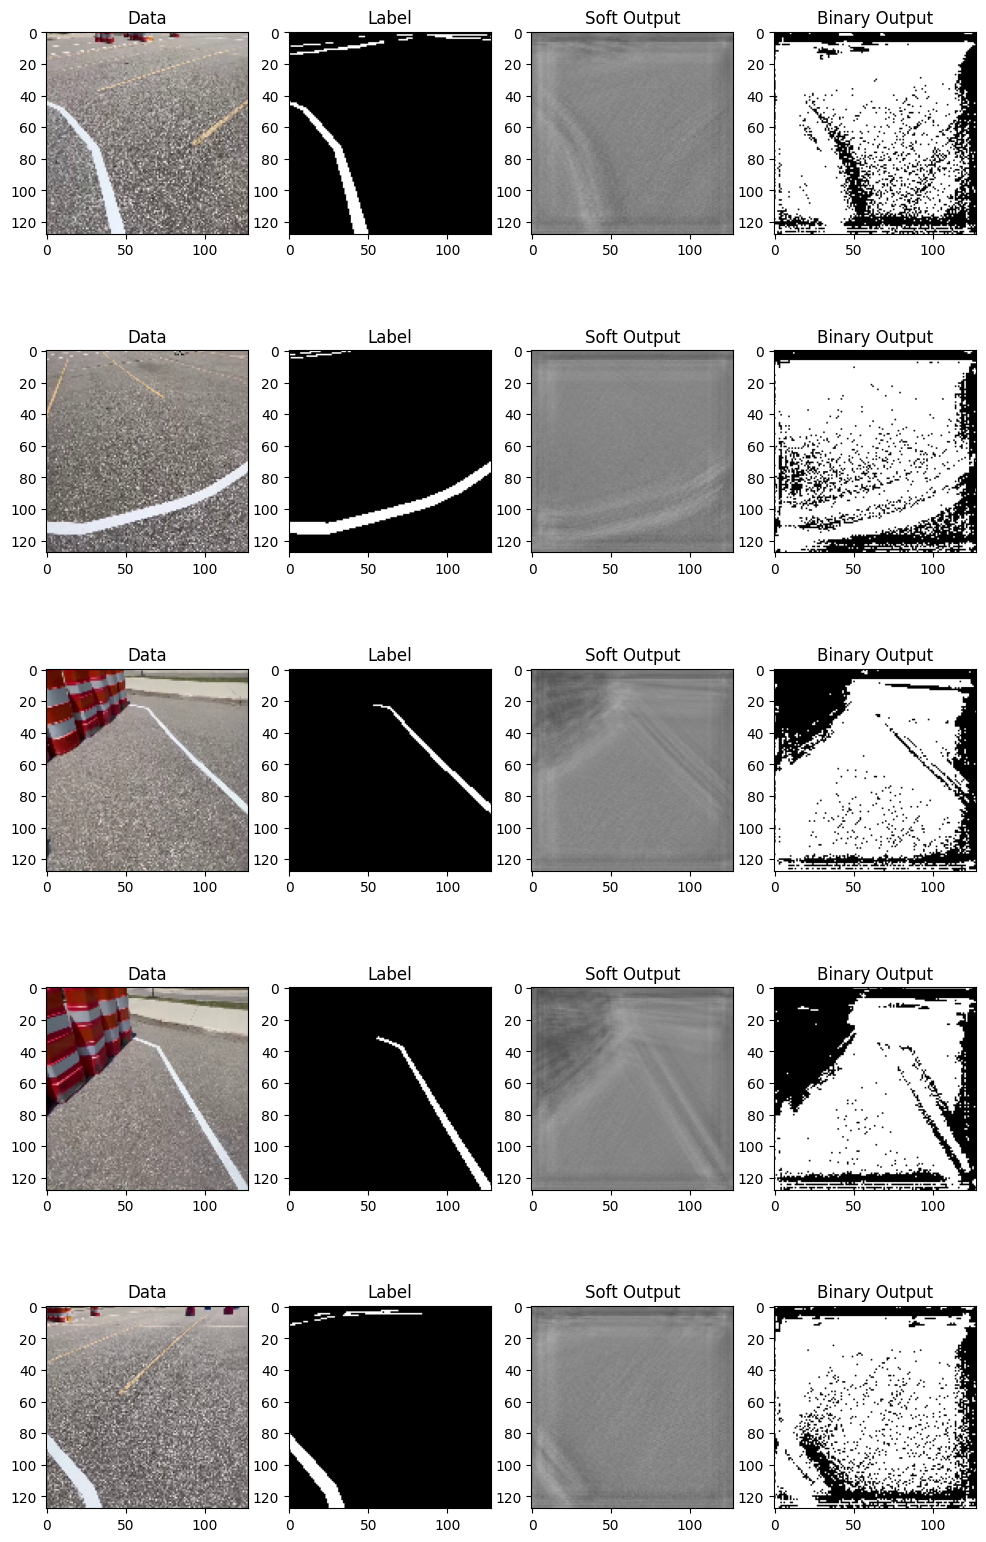

In [10]:
test_model_on_benchmarks(
    model = model,
    device = device,
    all_benchmarks = True,
    report_results = True
)